In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Code for plotting ACF,PACF and Q-Q plots. Taken from BlackArbs LLC website
import os
import sys

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


#import matplotlib.pyplot as plt
import matplotlib as mpl

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [4]:
#Load Data
df = pd.read_excel('C:\\Users\\Hrushikesh\\Downloads\\Heston-main\\2018_2020_NiftyIV.xlsx')

In [5]:
#Create a label to identify the transition from one expiry to another. This piece of code identifies the change in
#days to expiry and creates a abel for it.
df['Label'] = 0
df['Label'] = np.where(df['Days_To_Expiy']>=df['Days_To_Expiy'].shift(-1),0,1)
#df.head(5)

In [6]:
#Create a list of dataframes that group the data by dates
dfDailyList = []
for group in df.groupby(df['Date/Time'].dt.date):
    dfDailyList.append(group[1])

In [7]:
#Slice the main data by expiry, create a list of dataframes for different expiries
index_list = df[df['Label']==1].index.tolist()
dfExpiryList = []
for i in range(0,len(index_list)):
    if(i==0):
        dfExpiryList.append(df.iloc[:index_list[i]+1,:])
    else:
        dfExpiryList.append(df.iloc[index_list[i-1]+1:index_list[i]+1,:])

In [8]:
#Create an OHLC data for price and volatility on day basis
from datetime import datetime
column_names = ['Date/Time','vol_Open','vol_High','vol_Low','vol_Close','price_Open','price_High','price_Low','price_Close','Label']
dfDailyOHLCList = pd.DataFrame(columns=column_names)
for dftemp in dfDailyList:
        dte = dftemp['Date/Time'].iloc[0].date()
        vol_Open = dftemp['Avg_IV_ATM'].iloc[0]
        vol_Close = dftemp['Avg_IV_ATM'].iloc[-1]
        vol_High = dftemp['Avg_IV_ATM'].max()
        vol_Low = dftemp['Avg_IV_ATM'].min()
        price_Open = dftemp['Underlying_Fut'].iloc[0]
        price_Close = dftemp['Underlying_Fut'].iloc[-1]
        price_High = dftemp['Underlying_Fut'].max()
        price_Low = dftemp['Underlying_Fut'].min()
        label = dftemp['Label'].iloc[-1]
        dfDailyOHLCList = dfDailyOHLCList.append({'Date/Time':dte,'vol_Open':vol_Open,'vol_High':vol_High,'vol_Low':vol_Low,'vol_Close':vol_Close,'price_Open':price_Open,'price_High':price_High,'price_Low':price_Low,'price_Close':price_Close,'Label':label},ignore_index=True)
        

In [9]:
#Extract data at 3.15 pm everydat
column_names = ['Date','vol','price']
dfDailyEODList = pd.DataFrame(columns=column_names)
my_time_string = "15:15:00"
my_time = datetime.strptime(my_time_string, "%H:%M:%S")

i=0
for dftemp in dfDailyList:
        dte = dftemp['Date/Time'].iloc[0].date()
        vol = dftemp[dftemp['Date/Time'][:].dt.time == my_time.time()]['Avg_IV_ATM'].to_numpy()
        price = dftemp[dftemp['Date/Time'][:].dt.time == my_time.time()]['Underlying_Fut'].to_numpy()
        #label = dftemp[dftemp['Date/Time'][:].dt.time == my_time.time()]['Label']
        if(vol.size == 0):
            continue
        else:
            vol1=vol[0,]
            price1=price[0,]
        i=i+1
        dfDailyEODList = dfDailyEODList.append({'Date':dte,'vol':vol1,'price':price1},ignore_index=True)

Iteration:      5,   Func. Count:     32,   Neg. LLF: 12876.667339151849
Iteration:     10,   Func. Count:     60,   Neg. LLF: 12432.869727357254
Iteration:     15,   Func. Count:     84,   Neg. LLF: 12432.727560367111
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12432.727560366628
            Iterations: 15
            Function evaluations: 84
            Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12432.7
Distribution:                  Normal   AIC:                           24873.5
Method:            Maximum Likelihood   BIC:                           24902.3
                                        No. Observations:                10000
Date:                Sun, Dec 20 2020   Df Residuals:                     9996
Time:                        06:31:37   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.6892e-03  6.739e-03     -0.547      0.584 [-1.690e-02,9.518e-03]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.1989  9.376e-03     21.212 7.386e-100 [  0.181,  0.217]
alpha[1]       0.4940  1.857e-02     26.608 5.504e-156 [  0.458,  0.530]
beta[1]        0.3112  1.687e-02     18.442  6.030e-76 [  0.278,  0.344]
========================================================================

Covariance estimator: robust
"""

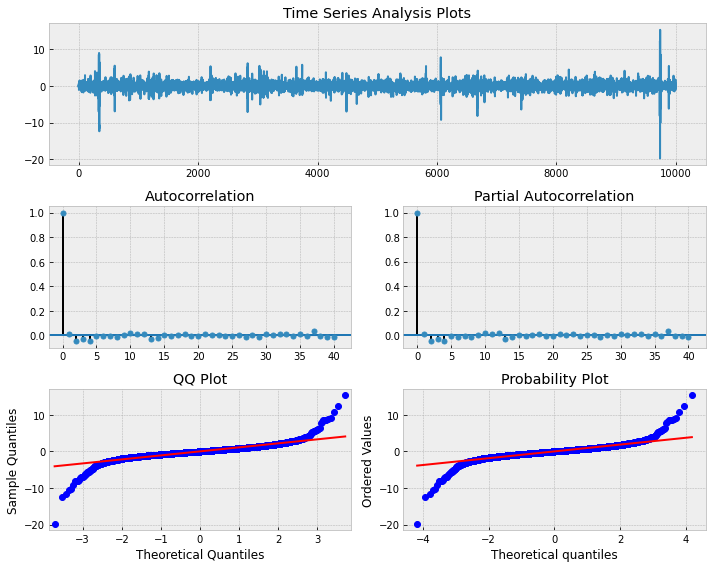

In [10]:
#A sample GARCH problem, taken from BlackArbs LLC
#This works spectacularly
from arch import arch_model
a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps)
am = arch_model(eps)
res = am.fit(update_freq=5)
res.summary()

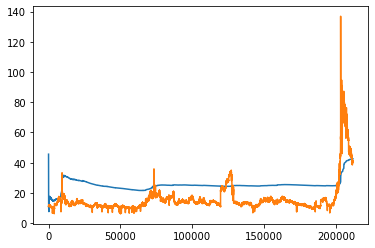

In [11]:
#Volatility calculation based on given price data (1 min data). Interestingly, the realized volatility is higher than the IV for
# 1 minute data. Second, the realized vol is very smooth, which is unexpected because one would expect more number of 
#jumps when the volatility is rough

df['Return'] = np.log(df['Underlying_Fut']/df['Underlying_Fut'].shift(1))
#df['Cum Return'] = df['Return'].cumsum()
#df['Return_Vol'] = np.sqrt(df['Return'].apply(lambda x: x*x))*np.sqrt(252)*100
#Question is: Should we consider the 1440 minutes in the day or just the minutes from the trading time/
#Currently, I consider the number of minutes in entire day.
df['Return_Vol'] = df['Return'].expanding().std()*np.sqrt(252*1440)*100
layout = (1, 1)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
df['Return_Vol'].plot(ax=ts_ax)
df['Avg_IV_ATM'].plot(ax=ts_ax)
plt.show()

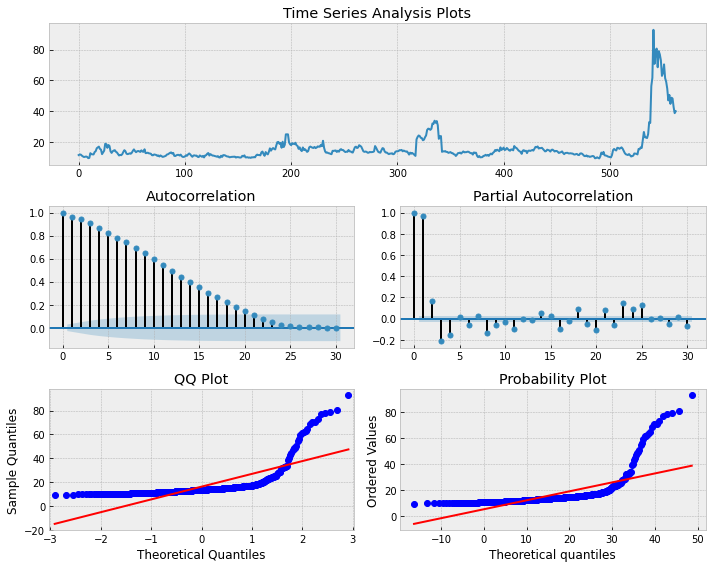

In [12]:
#Plot of volatilities @ 3.15 pm data
tsplot(dfDailyEODList['vol'],lags=30)

In [13]:
#GARCH on EOD data, note that the beta value shows fit is imperfect
am = arch_model(dfDailyEODList['vol'],p=1,q=1)
res = am.fit(update_freq=5)
res.summary()

Iteration:      5,   Func. Count:     31,   Neg. LLF: 1489.9606208944492
Iteration:     10,   Func. Count:     60,   Neg. LLF: 4516.506104268186
Iteration:     15,   Func. Count:     86,   Neg. LLF: 1282.1945350912445
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1282.1924660304203
            Iterations: 18
            Function evaluations: 100
            Gradient evaluations: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                      -0.098
Mean Model:             Constant Mean   Adj. R-squared:                 -0.098
Vol Model:                      GARCH   Log-Likelihood:               -1282.19
Distribution:                  Normal   AIC:                           2572.38
Method:            Maximum Likelihood   BIC:                           2589.72
                                        No. Observations:                  563
Date:                Sun, Dec 20 2020   Df Residuals:                      559
Time:                        06:31:42   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.8079      0.196     65.441      0.000 [ 12.424, 13.191]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.6066      0.164      3.692  2.227e-04      [  0.285,  0.929]
alpha[1]       1.0000  8.339e-02     11.991  3.948e-33      [  0.837,  1.163]
beta[1]        0.0000  3.390e-03      0.000      1.000 [-6.645e-03,6.645e-03]
=============================================================================

Covariance estimator: robust
"""

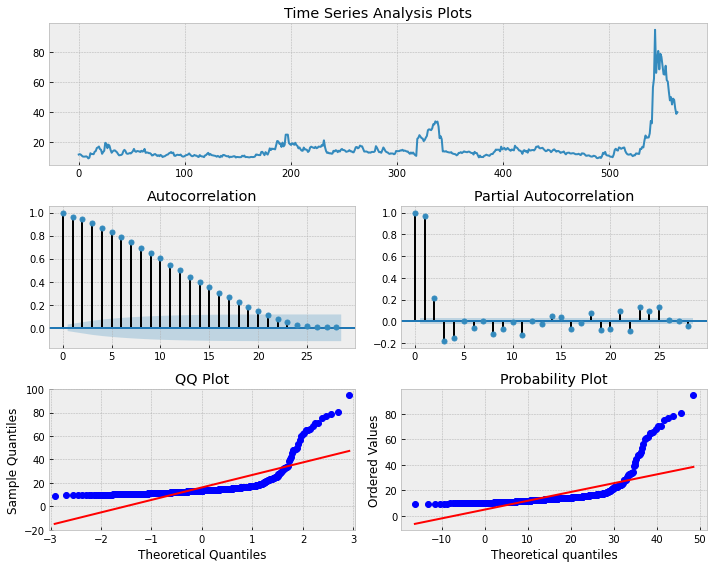

In [14]:
#Plot of volatilities using close data
_ = tsplot(dfDailyOHLCList['vol_Close'])

Iteration:      5,   Func. Count:     31,   Neg. LLF: 188.24504962970852
Iteration:     10,   Func. Count:     61,   Neg. LLF: 186.59567056757484
Iteration:     15,   Func. Count:     86,   Neg. LLF: 186.2726157686184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 186.2726157686184
            Iterations: 16
            Function evaluations: 90
            Gradient evaluations: 16
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              vol_Close   R-squared:                      -0.110
Mean Model:             Constant Mean   Adj. R-squared:                 -0.110
Vol Model:                      GARCH   Log-Likelihood:               -186.273
Distribution:                  Normal   AIC:                           380.545
Method:            Maximum Likelihood   BIC:                           390.966
                                        No. Observations:                  100
Date:               

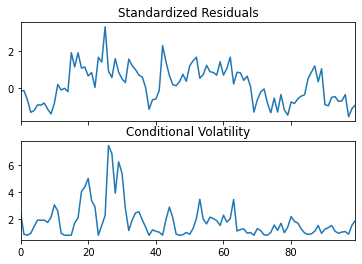

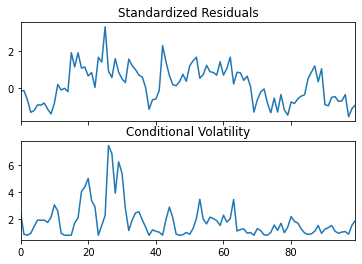

In [15]:
#GARCH on the close data from OHLC data
am = arch_model(dfDailyOHLCList['vol_Close'][:100],p=1,q=1)
res = am.fit(update_freq=5)
print(res.summary())
res.plot()

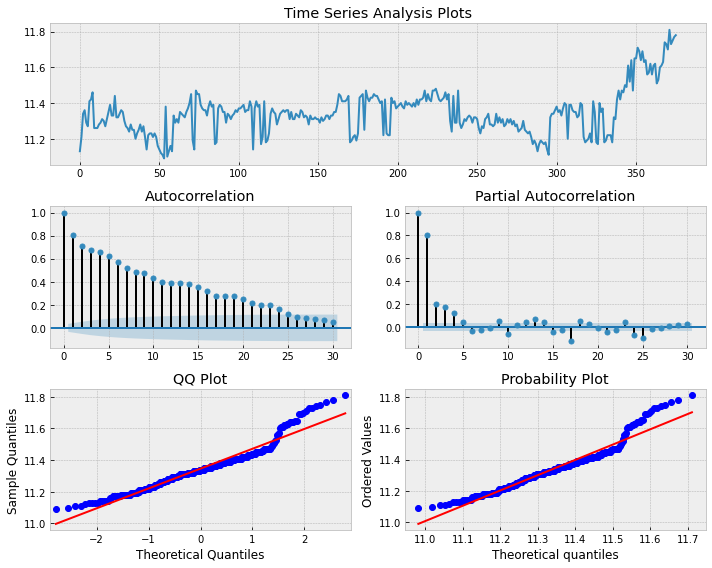

In [16]:
#GARCH on the first daily OHLC data
dftemp = dfDailyList[0]
tsplot(dftemp['Avg_IV_ATM'],lags=30)

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01573. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     41,   Neg. LLF: 219.3150380120916
Iteration:     10,   Func. Count:     72,   Neg. LLF: -411.69040017227746
Optimization terminated successfully    (Exit mode 0)
            Current function value: -411.69239367345006
            Iterations: 14
            Function evaluations: 86
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Avg_IV_ATM   R-squared:                      -0.039
Mean Model:             Constant Mean   Adj. R-squared:                 -0.039
Vol Model:                      GARCH   Log-Likelihood:                411.692
Distribution:                  Normal   AIC:                          -815.385
Method:            Maximum Likelihood   BIC:                          -799.666
                                        No. Observations:                  376
Date:                Sun, Dec 20 2020   Df Residuals:                      372
Time:      

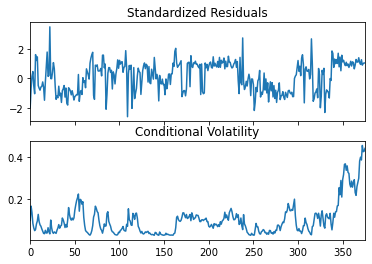

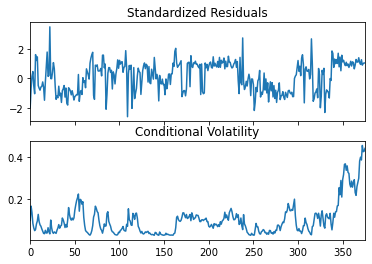

In [17]:
#GARCH on the first daily OHLC data, note it did not converge
am = arch_model(dftemp['Avg_IV_ATM'],p=1,q=1)
res = am.fit(update_freq=5)
print(res.summary())
res.plot()

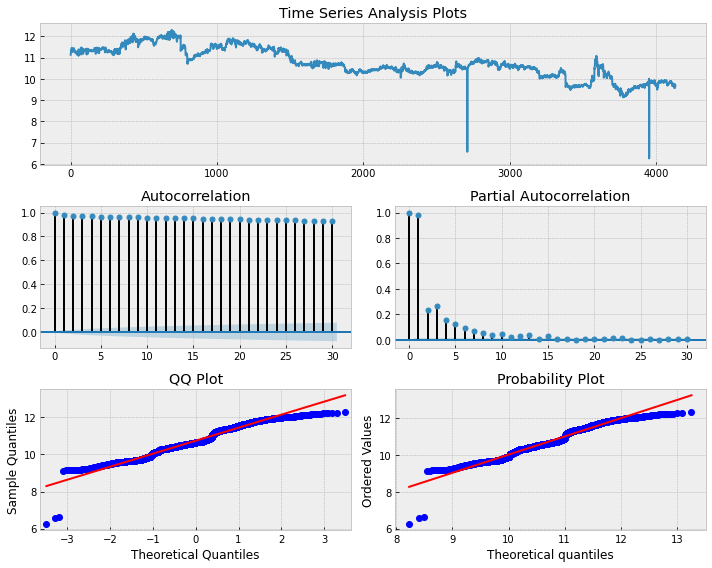

In [18]:
#GARCH on the expiry data
dftemp = dfExpiryList[0]
tsplot(dftemp['Avg_IV_ATM'],lags=30)

Iteration:      5,   Func. Count:     37,   Neg. LLF: 24162.773531337534
Iteration:     10,   Func. Count:     71,   Neg. LLF: 3530.332534205185
Iteration:     15,   Func. Count:    107,   Neg. LLF: 2325.24180677163
Iteration:     20,   Func. Count:    137,   Neg. LLF: 2035.001217397983
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2034.8429247995061
            Iterations: 27
            Function evaluations: 165
            Gradient evaluations: 24
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Avg_IV_ATM   R-squared:                      -0.017
Mean Model:             Constant Mean   Adj. R-squared:                 -0.017
Vol Model:                      GARCH   Log-Likelihood:               -2034.84
Distribution:                  Normal   AIC:                           4077.69
Method:            Maximum Likelihood   BIC:                           4102.99
                           

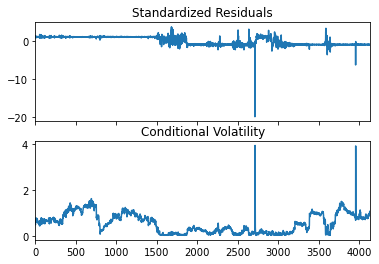

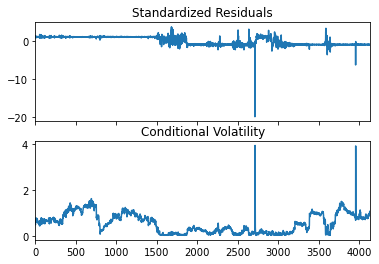

In [19]:
#GARCH on the first daily OHLC data, only this model looks a bit better. 
#To be done - Loop for all days
am = arch_model(dftemp['Avg_IV_ATM'],p=1,q=1)
res = am.fit(update_freq=5)
print(res.summary())
res.plot()

In [20]:
#We consider the data for first expiry and calculate the volatility 
dftemp['Return'] = np.log(dftemp['Underlying_Fut']/dftemp['Underlying_Fut'].shift(1))
#Here, I use the number of minutes of the trading day instead of entire day.
#Now, the realized Vol is lower than the implied vol.
dftemp['Vol'] = dftemp['Return'].expanding().std()*np.sqrt(252*376)*100
dftemp.tail(5)

<ipython-input-20-84714330e9a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp['Return'] = np.log(dftemp['Underlying_Fut']/dftemp['Underlying_Fut'].shift(1))
<ipython-input-20-84714330e9a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp['Vol'] = dftemp['Return'].expanding().std()*np.sqrt(252*376)*100


,Ticker,Date/Time,Underlying_Fut,Expiry_Cont,Days_To_Expiy,Avg_IV_ATM,Unnamed: 6,Label,Return,Vol
4128,NIFTY-I.NFO,2018-01-15 15:26:00,10738.25,2020-01-18,10.010,9.58,NaN,0,-0.000023,7.671261
4129,NIFTY-I.NFO,2018-01-15 15:27:00,10740.55,2020-01-18,10.008,9.70,NaN,0,0.000214,7.670990
4130,NIFTY-I.NFO,2018-01-15 15:28:00,10744.00,2020-01-18,10.005,9.74,NaN,0,0.000321,7.671561
4131,NIFTY-I.NFO,2018-01-15 15:29:00,10745.05,2020-01-18,10.002,9.72,NaN,0,0.000098,7.670762
4132,NIFTY-I.NFO,2018-01-15 15:30:00,10745.50,2020-01-18,10.000,9.67,NaN,1,0.000042,7.669854


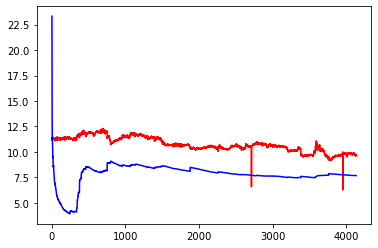

In [21]:
#Plot of the vol from the previous cell
dftemp['Avg_IV_ATM'].plot(color='r')
dftemp['Vol'].plot(color='b')

In [22]:
#Use OHLC data for vol calculation. Since we use the daily data here, no need for multiplication by minute.
#We use two different volatility definitions - standard volatility and Parkinson volatility
dfDailyOHLCList['Return'] = np.log(dfDailyOHLCList['price_Close']/dfDailyOHLCList['price_Close'].shift(1))
dfDailyOHLCList['Parkinson_Return'] = np.log(dfDailyOHLCList['price_High']/dfDailyOHLCList['price_Low'])**2
#dfDailyOHLCList['count'] = np.arange(1,len(dfDailyOHLCList)+1)
dfDailyOHLCList['Vol'] = dfDailyOHLCList['Return'].expanding().std()*np.sqrt(252)*100
dfDailyOHLCList['Parkinson_Vol'] = np.sqrt(dfDailyOHLCList['Parkinson_Return'].expanding().mean())/np.sqrt(4*np.sqrt(2))*np.sqrt(252)*100
dfDailyOHLCList.head(5)

,Date/Time,vol_Open,vol_High,vol_Low,vol_Close,price_Open,price_High,price_Low,price_Close,Label,Return,Parkinson_Return,Vol,Parkinson_Vol
0,2018-01-01,11.13,11.81,11.09,11.78,10543.95,10556.50,10487.00,10490.00,0,NaN,0.000044,NaN,4.408706
1,2018-01-02,11.38,12.30,11.38,12.02,10515.00,10519.35,10439.05,10463.35,0,-0.002544,0.000059,NaN,4.774657
2,2018-01-03,11.31,11.91,10.70,11.65,10497.20,10537.95,10457.95,10472.00,0,0.000826,0.000058,3.782929,4.880743
3,2018-01-04,11.55,11.82,10.88,10.94,10481.00,10536.75,10467.00,10535.00,0,0.005998,0.000044,6.829897,4.772732
4,2018-01-05,10.77,11.07,10.32,10.40,10545.00,10580.80,10537.75,10578.20,0,0.004092,0.000017,5.964389,4.438931


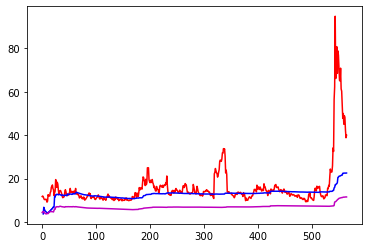

In [23]:
#Plotting volatilities - red:IV, blue- realized Vol, magenta - Parkinson Vol
#Realized vol is very close to IV, Parkinson vol is lower but is qualitatively similar to realized vol
#Again, on daily basis, the vols are much smoother than the rough vols. 
dfDailyOHLCList['vol_Close'].plot(color='r')
dfDailyOHLCList['Vol'].plot(color='b')
dfDailyOHLCList['Parkinson_Vol'].plot(color='m')

In [30]:
#Calculate Hurst Coefficient for OHLC data, simplified = True
from hurst import compute_Hc
#H_OHLC,c,data = compute_Hc(dfDailyOHLCList['vol_Close'],kind='price',simplified=True)
#print(H_OHLC)
dft = dfDailyOHLCList.dropna()
H_OHLC,c,data = compute_Hc(dft['Vol'],kind='price',simplified=True)
print("Daily OHLC based Hurst (price):" + str(H_OHLC))
H_OHLC,c,data = compute_Hc(dft['Vol'],kind='change',simplified=True)
print("Daily OHLC based Hurst (change):"+ str(H_OHLC))
H_OHLC,c,data = compute_Hc(dft['Vol'],kind='random_walk',simplified=True)
print("Daily OHLC based Hurst (random_walk):" + str(H_OHLC))

Daily OHLC based Hurst (price):0.6130117865462172
Daily OHLC based Hurst (change):-0.04844036322296828
Daily OHLC based Hurst (random_walk):0.5002524340166487


In [31]:
#Calculate Hurst Coefficient for OHLC data , simplified = False
#With simplified=False, volatilities are more smooth
#H_OHLC,c,data = compute_Hc(dfDailyOHLCList['vol_Close'],kind='price',simplified=False)
#print(H_OHLC)
dft = dfDailyOHLCList.dropna()
H_OHLC,c,data = compute_Hc(dft['Vol'],kind='price',simplified=False)
print("Daily OHLC based Hurst (price):" + str(H_OHLC))
H_OHLC,c,data = compute_Hc(dft['Vol'],kind='change',simplified=False)
print("Daily OHLC based Hurst (change):"+ str(H_OHLC))
H_OHLC,c,data = compute_Hc(dft['Vol'],kind='random_walk',simplified=False)
print("Daily OHLC based Hurst (random_walk):" + str(H_OHLC))

Daily OHLC based Hurst (price):0.6554186651537531
Daily OHLC based Hurst (change):0.8767715655920783
Daily OHLC based Hurst (random_walk):0.691652577268104
